In [8]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt

from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd
import numpy as np
import arviz as az

from jax import lax, config
config.update("jax_enable_x64", True)

numpyro.set_host_device_count(2)

In [9]:
# import scenario_generator.utils as u
# import datetime

# current_date = datetime.date(2023, 7, 28)
# t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-datetime.timedelta(days=365*2), current_date)
# t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-datetime.timedelta(days=365*2), current_date)
# t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-datetime.timedelta(days=365*2), current_date)

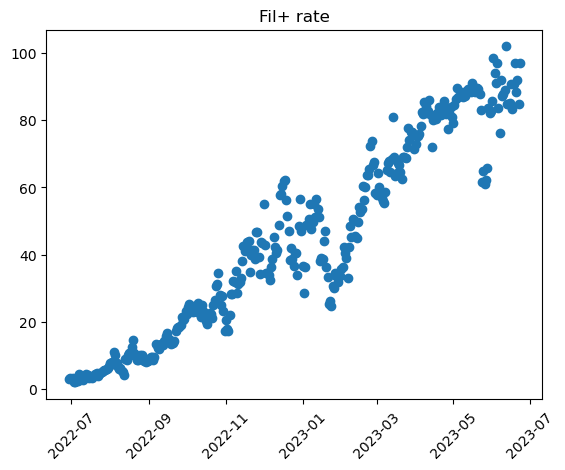

In [10]:
df_rbp=pd.read_csv("offline_data/Sector_Onboarding_Breakdown_by_Sector_RBP.csv",parse_dates=['stateTime'])
df_deal=pd.read_csv("offline_data/Newly_Committed_Deal_by_Sealing_Type.csv",parse_dates=['stateTime'])

fil_p_rate = 100 * (df_deal.Total.values / 1000) / df_rbp.Total.values
cc_rate = 100 - fil_p_rate

plt.scatter(df_rbp['stateTime'], fil_p_rate)
plt.title("Fil+ rate");
plt.xticks(rotation=45);

In [17]:
def logistic_growth_model(x, y=None):
    
    # priors
    x0 = numpyro.sample("x0", dist.Normal(x.shape[0] // 2, 50)) # midpoint
    k = numpyro.sample("k", dist.Normal(0, 0.1)) # growth rate
    L = numpyro.sample("L", dist.Beta(1, 1)) #ccarrying capacity
    
    # logistic model
    filp = numpyro.deterministic("filp", L / (1 + jnp.exp(-k * (x - x0))))

    # Normal likelihood --- note, won't constrain output to correct [0,1] support
#     sigma = numpyro.sample("error", dist.HalfNormal(0.1))
#     numpyro.sample(
#         "obs",
#         dist.Normal(filp, sigma),
#         obs=y,
#     )
    
    # Bernoulli likelihood version
    numpyro.sample(
        "obs",
        dist.Bernoulli(probs=filp),
        obs=y,
    )

In [18]:
mcmc = MCMC(
    NUTS(logistic_growth_model, dense_mass=True),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         L      0.91      0.06      0.92      0.83      1.00   1123.73      1.00
         k      0.02      0.00      0.02      0.01      0.02   1646.83      1.00
        x0    185.54     14.94    186.55    162.57    210.71   1332.64      1.00

Number of divergences: 0


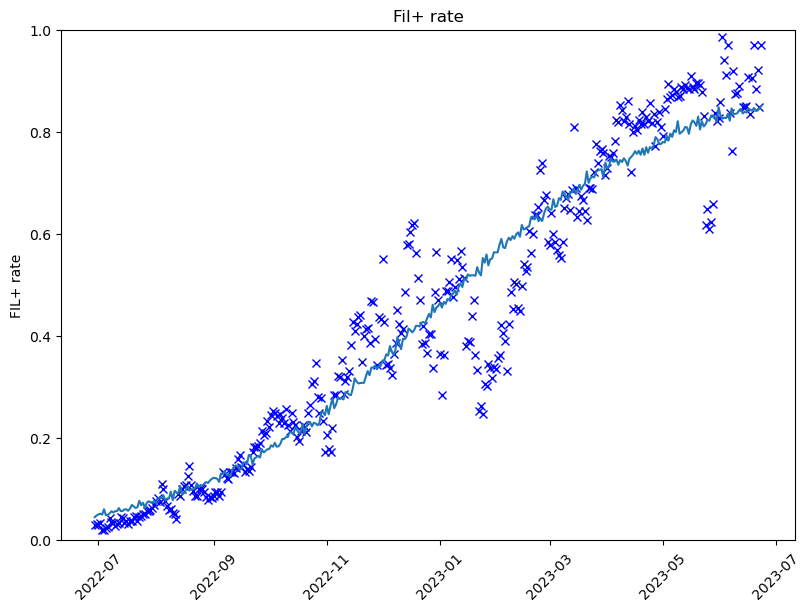

In [23]:
day = df_deal.index.values
data = np.array([cc_rate,fil_p_rate]).T / 100

mcmc.run(PRNGKey(1), x=day, y=data.T[1])
mcmc.print_summary()


predictive = Predictive(logistic_growth_model, mcmc.get_samples())
preds = predictive(PRNGKey(1), x=day)["obs"]
mu = jnp.mean(preds, 0) 

# Note the quantiles are not well defined for Bernoulli likelihood
# But this would be fine with normal likelihood
# pi = jnp.percentile(preds,  jnp.array([25, 75]), 0)


plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(df_rbp['stateTime'], data[:, 1], "bx", label="Deal RBP data")
# plt.fill_between(df_rbp['stateTime'], pi[0, :], pi[1, :], color="k", alpha=0.2)
plt.plot(df_rbp['stateTime'], mu)
plt.title("Fil+ rate");
plt.gca().set(ylim=(0, 1), ylabel="FIL+ rate")
plt.xticks(rotation=45);

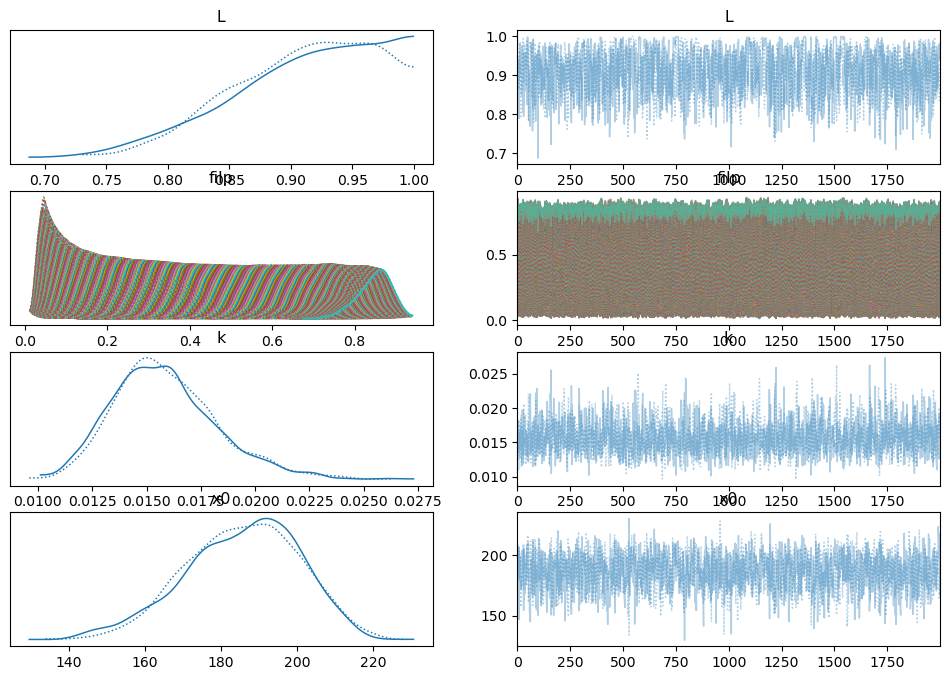

In [24]:
az.plot_trace(az.from_numpyro(mcmc)); # slow because of filp

In [25]:
carrying_capacity = mcmc.get_samples()['L']
print("Carrying capacity mean and [Q10,Q90]:")
mu_L, q10q90_L = jnp.median(carrying_capacity),  jnp.percentile(carrying_capacity,  jnp.array([10, 90]), 0)
mu_L, q10q90_L

Carrying capacity mean and [Q10,Q90]:


(Array(0.91827231, dtype=float64),
 Array([0.82701223, 0.98263644], dtype=float64))

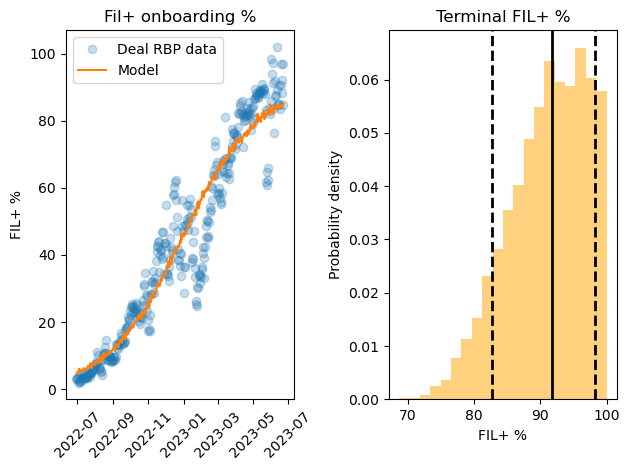

<Figure size 800x1200 with 0 Axes>

In [26]:

fig, ax = plt.subplots(1, 2);
ax[0].plot(df_rbp['stateTime'], 100*data[:, 1], "o", alpha=0.25, label="Deal RBP data");
ax[0].plot(df_rbp['stateTime'], 100*mu, label="Model")
ax[0].set_title("Fil+ onboarding %");
ax[0].set_ylabel("FIL+ %")
ax[0].tick_params('x', labelrotation=45)
ax[0].legend()

ax[1].hist(100*mcmc.get_samples()['L'], density=True, color='orange', bins=20, alpha=0.5);
ax[1].set_title("Terminal FIL+ %");
ax[1].set_xlabel("FIL+ %")
ax[1].axvline(100*mu_L, color='k',  linewidth=2)
ax[1].axvline(100*q10q90_L[0], color='k', linestyle='dashed', linewidth=2)
ax[1].axvline(100*q10q90_L[1], color='k', linestyle='dashed', linewidth=2)
ax[1].set_ylabel("Probability density");

plt.tight_layout();
plt.figure(figsize=(8, 12), constrained_layout=True);

In [27]:
print(f"Inferred distribution for terminal FIL+ %,\n median = {np.round(100*mu_L,0)}, quantiles [Q10, Q90] = {np.round(100*q10q90_L,0)}")

Inferred distribution for terminal FIL+ %,
 median = 92.0, quantiles [Q10, Q90] = [83. 98.]
